# Aerodynamic Splatting

In [1]:
import numpy as np
from sympy import symbols, diff, Quaternion, exp, Matrix, lambdify, sin, cos, simplify
#from sympy.physics.mechanics import *
import random
from IPython.display import display
import matplotlib.pyplot as plt
from aerosplat import *

## Symbolic Math

## Equation for quaternion
We provide two options for obtaining the quaternon.
In the case where a `numpy` array with four quaternion components are provided, we will obtain using the standard syntax `Quaternion(qw, qx, qy, qz)`.
In the case where a single component is provided, we will assume that this is a planar model with an angle evaluated about the $z$-axis, and obtain with the `Quaternion.from_axis_angle` class method.
We also will create the `idx_dimension` variable which shrinks subsequent matrices and vectors to use only the first two ($x$ and $y$) components.

In [2]:
display(quaternion_2d)

cos(θ/2) + 0*i + 0*j + sin(θ/2)*k

In [3]:
display(quaternion_3d)

q_w + q_x*i + q_y*j + q_z*k

## Equation for gaussian

The Gaussian equation that is created below uses the variance term _not-squared_, while in the plot I square this term.
There is reason for this; the variance that I will use below is going to be of the form

$\texttt{variance} = \sum_{i=1}^3 \left( \frac{x_i - \bar{x}_i}{s_i} \right)^2$

where $x_i$ is a position coordinate for where we are measuring, $\bar{x}_i$ is the position coordinate for the center of the Gaussian, and $s_i$ is a scale coefficient representing one standard deviation in the direction of that coordinate.
Traditionally, we would evaluate the Gaussian at some count of standard deviations, which would derive from the square-root of the above expression.
To avoid taking a square-root, just to subsequently square the term again, we create the Gaussian as a function of the variance directly.
However, the plot below shows an evaluation of the Gaussian with respect to standard deviations.

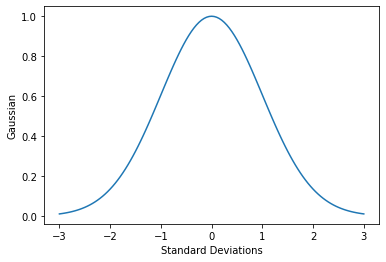

In [4]:
stdev = np.linspace(-3, 3, 121);
plt.plot(stdev, np.exp(-0.5 * stdev**2));
plt.xlabel("Standard Deviations");
plt.ylabel("Gaussian");

Here we create a function that obtains the rotation matrix from the quaternion, along with some simplification steps.
First, we substitute a value of 1 for the quaternion norm, as we will ensure that it is always a proper unit quaternion.
Second, we call the standard `simplify()` function.

In [5]:
display(rotation_eqn_2d)

Matrix([
[cos(θ), -sin(θ)],
[sin(θ),  cos(θ)]])

In [6]:
display(rotation_eqn_3d)

Matrix([
[-2*q_y**2 - 2*q_z**2 + 1,   -2*q_w*q_z + 2*q_x*q_y,    2*q_w*q_y + 2*q_x*q_z],
[   2*q_w*q_z + 2*q_x*q_y, -2*q_x**2 - 2*q_z**2 + 1,   -2*q_w*q_x + 2*q_y*q_z],
[  -2*q_w*q_y + 2*q_x*q_z,    2*q_w*q_x + 2*q_y*q_z, -2*q_x**2 - 2*q_y**2 + 1]])

Velocity away from the center of the Gaussian takes the form

$\boldsymbol{x} = (x, y, z, u, v, w, s_x, s_y, s_z, q_w, q_x, q_y, q_z)$

$\boldsymbol{x}_p = (x_p, y_p, z_p)$

$\boldsymbol{v(\boldsymbol{x}, \boldsymbol{x}_p)} = \boldsymbol{v_0(\boldsymbol{x})} g(\boldsymbol{x}, \boldsymbol{x}_p)$

In [7]:
display(Matrix(velocity_eqn_2d))

Matrix([
[u*exp(-0.5*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2/s_y**2 - 0.5*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2/s_x**2)],
[v*exp(-0.5*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2/s_y**2 - 0.5*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2/s_x**2)]])

We see the variance contained in the exponent

In [8]:
display(variance_eqn_2d)

((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2/s_y**2 + ((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2/s_x**2

### Velocity derivative equations

Velocity is 1x2 or 1x3

Variance derivates are 1xN

$$
\frac{\partial \boldsymbol{v(\boldsymbol{x}, \boldsymbol{x}_p)} }{\partial x_i}
= 
\frac{\partial \boldsymbol{v_0(\boldsymbol{x})}}{\partial x_i}
g(\boldsymbol{x}, \boldsymbol{x}_p)
+
\boldsymbol{v_0(\boldsymbol{x})}
\frac{\partial g(\boldsymbol{x}, \boldsymbol{x}_p)}{\partial x_i}
$$

## Splatting Class

In [9]:
a = AeroSplat(
    position=[0, 0], 
    velocity=[1, 0],
    scale=[1, 1],
    orientation=[0]
)
display(a)
display(a.quaternion)
display(a.rotation_matrix)
display(a.velocity_at(np.array([2, 0])))
display(a.differential_velocity_at(np.array([2, 0])))

AeroSplat(position=[0 0], velocity=[1 0], scale=[1 1], orientation=[0])

1 + 0*i + 0*j + 0*k

array([[ 1., -0.],
       [ 0.,  1.]])

array([0.13533528, 0.        ])

array([[ 0.27067057,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.13533528,  0.        ],
       [ 0.        ,  0.13533528],
       [ 0.54134113,  0.        ],
       [ 0.        ,  0.        ],
       [-0.        , -0.        ]])

## Boundary Condition Class

In [10]:
source_boundary = LineBoundary(point0=[0, -1], point1=[0, 1], velocity=[10, 0])
plate_boundary = LineBoundary(point0=[1, -0.1], point1=[1, 0.1], velocity=[0, 0])
print(source_boundary)
print(source_boundary.point_at_random())

LineBoundary(point0=[ 0 -1], point1=[0 1], velocity=[10  0])
[0.        0.9498788]


## Problem Definition Class

In [11]:
problem = AeroSplatProblem(
    domain_x=[0, 2], 
    domain_y=[-1, 1],
    boundaries=[source_boundary, plate_boundary],
    spawn=20
)
print(problem)

AeroSplatProblem(
  domain_x=[0 2]
  domain_y=[-1  1]
  boundaries=[LineBoundary(point0=[ 0 -1], point1=[0 1], velocity=[10  0]), LineBoundary(point0=[ 1.  -0.1], point1=[1.  0.1], velocity=[0 0])]
)


In [12]:
print(problem.velocity_on_grid(2, 2))
print(problem.ndims)
print(problem.splats)

[[[-5.96546501e-04  4.29732423e-04]
  [ 3.18415893e-04 -5.91276843e-04]]

 [[ 1.47719463e-09  3.41088502e-09]
  [ 7.95658158e-01  4.73015535e-01]]]
2
[AeroSplat(position=[1.0357539  0.66019156], velocity=[-0.15006131 -0.04991682], scale=[0.0574897  0.00150796], orientation=[0.37122241]), AeroSplat(position=[ 0.2847263  -0.82782761], velocity=[-0.39568316  0.2850371 ], scale=[0.18054618 0.08658485], orientation=[-2.52061402]), AeroSplat(position=[ 0.52749397 -0.64580445], velocity=[-0.64049223 -1.33694845], scale=[0.02692746 0.12112047], orientation=[-0.0107173]), AeroSplat(position=[1.24448516 0.49714416], velocity=[-1.13855848  0.26002718], scale=[0.04770798 0.14683956], orientation=[1.49796971]), AeroSplat(position=[0.84161262 0.26707103], velocity=[0.8388419  1.08141809], scale=[0.11287095 0.14763783], orientation=[1.13916186]), AeroSplat(position=[ 0.90149285 -0.56596272], velocity=[-0.92248672 -0.44432497], scale=[0.19754818 0.04089679], orientation=[1.12636425]), AeroSplat(positi

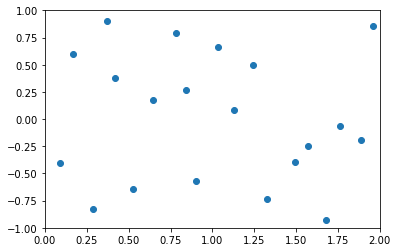

In [13]:
splat_positions = np.array([[splat.position[0], splat.position[1]] for splat in problem.splats])
plt.plot(splat_positions[:, 0], splat_positions[:, 1], "o");
plt.xlim(problem.domain_x);
plt.ylim(problem.domain_y);

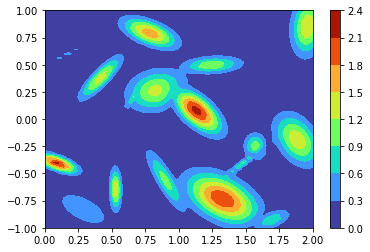

In [14]:
nx = 101
ny = 51
grid = problem.point_grid(nx, ny)
velocity_field = problem.velocity_on_grid(nx, ny)
contour_x = np.array([grid[0, k, 0] for k in range(nx)])
contour_y = np.array([grid[j, 0, 1] for j in range(ny)])
contour_z = np.array([[np.linalg.norm(velocity_field[j, k, :]) for k in range(nx)] for j in range(ny)])
plt.contourf(contour_x, contour_y, contour_z, cmap="turbo");
plt.colorbar();

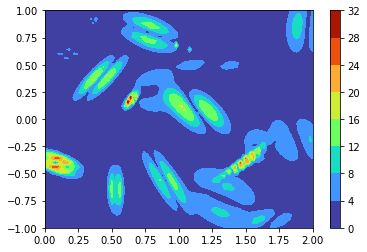

In [15]:
gradient_field = problem.velocity_gradient_on_grid(nx, ny)
contour_z = np.array([[np.linalg.norm(gradient_field[j, k, :]) for k in range(nx)] for j in range(ny)])
plt.contourf(contour_x, contour_y, contour_z, cmap="turbo");
plt.colorbar();